# Self-Supervised Learning and LodeSTAR

We'll explore self-supervised learning and how LodeSTAR exploits symmetries to locate microscopic particles.

## Create the Dataset

We start by creating the dataset, including a particle ...

In [1]:
import deeptrack as dt 
from numpy.random import uniform

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

2023-12-24 10:28:07.588632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


... and the imaging optics ...

In [2]:
optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

... which we combine in a simulation pipeline ...

In [3]:
import torch

simulation = (
    optics(particle) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)    

... which we have used to create a train and a test datasets.

In [4]:
train_dataset = dt.pytorch.Dataset(simulation, length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

Finally, we plot some examples of particles and the relative positions.

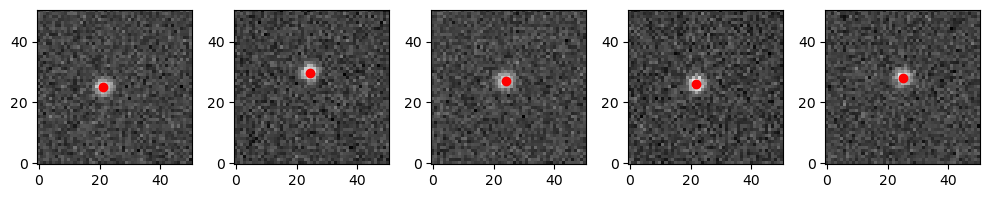

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
	image, position = test_dataset[i]
	plt.subplot(1, 5, i + 1)
	plt.imshow(image[0], cmap="gray", origin="lower")
	plt.scatter(position[1], position[0], c="r")
plt.tight_layout()
plt.show()

## Learn from Translations

We implement a cobvolutional neural network with a dense top, with two outputs corresponding to the coordinates of the particle position.

In [6]:
import deeplay as dl
import torch.nn as nn

backbbone = dl.ConvolutionalNeuralNetwork(in_channels=1,
                                          hidden_channels=[16, 32, 64],
                                          out_channels=128,
                                          pool=nn.MaxPool2d(2))

# We use LazyLinear not to have to calculate the output size of the CNN.
model = dl.Sequential(backbbone,
                      nn.Flatten(),
                      nn.LazyLinear(2)).create()

print(model)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (3): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We define the transformation that we will apply and with which we will teach the neural network to be consistent.

In [7]:
from kornia.geometry.transform import translate

def image_translation(batch, translation):
    """Translate a batch of images."""
    xy_flipped_translation = translation[:, [1, 0]]  # Flip the translation to match the image coordinate system.
    return translate(batch, xy_flipped_translation, padding_mode="reflection")

We also define the inverse transformation.

In [8]:
def inverse_translation(preds, applied_translation):
    """Invert translation of predicted positions."""
    return preds - applied_translation

In [9]:
from torch import rand

class ParticleLocalizer(dl.Application):
    """LodeSTAR implementation with translations."""
    
    def __init__(self, model, n_transforms=8, **kwargs):
        """Initialize the ParticleLocalizer."""
        self.model = model
        self.n_transforms = n_transforms
        super().__init__(**kwargs)

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)
    
    def random_arguments(self):
        """Generate random arguments for transformations."""
        return {
            "translation": (rand(self.n_transforms, 2).float().to(self.device) 
                       * 5 - 2.5)
        }

    def forward_transform(self, batch, translation):
        """Apply forward translation to the image."""
        return image_translation(batch, translation)

    def inverse_transform(self, preds, translation):
        """Apply inverse translation to the predictions."""
        return inverse_translation(preds, translation)

    def training_step(self, image, batch_idx):
        """Perform a single training step."""

        # Create a batch of images by applying random translations.
        image, *_ = image  # Take the first image from the input batch.
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        # Get arguments for the random transforms.
        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        # Predict the position of the particle.
        pred_position = self(transformed_batch)
        # Invert the translation to get the predicted position in the original image.
        pred_position = self.inverse_transform(pred_position, **kwargs)

        # Get average predicted position.
        average_pred_position = (pred_position
                                 .mean(dim=0, keepdim=True)
                                 .repeat(self.n_transforms, 1))  # Repeat the average position to match the batch size.

        # Calculate the loss. 
        # We minimize the distance between each prediction and their average
        # which effectively minimizes the variance of the predictions on the original image.
        loss = self.loss(pred_position, average_pred_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

We then instantiate the `ParticleLocalizer`.

In [10]:
localizer = ParticleLocalizer(
    model, n_transforms=8, loss=nn.L1Loss(), optimizer=dl.Adam(lr=5e-4)
).create()

We define the dataloader and trainer, and finally we train the model.

In [11]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### Evaluate Performance

We start by evaulating the positions of some particles in the test dataset.

In [12]:
images, positions = zip(*test_dataset)
images = torch.stack(images)
positions = torch.stack(positions)

predictions = localizer(images).detach().numpy()

We write a function to plot the predicted positions as a function of the real ones, and add it to `fnc_lodestar.py`.

```python
import matplotlib.pyplot as plt

def plot_position_comparison(positions, predictions):
    """Plot comparison between predicted and real particle positions."""

    plt.figure(figsize=(14, 8))
    grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

    plt.subplot(grid[1:, :3])
    plt.scatter(positions[:, 0], predictions[:, 0], alpha=.5) 
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Horizontal Position")
    plt.ylabel("Predicted Horizontal Position")
    plt.axis("equal")    

    plt.subplot(grid[1:, 4:])
    plt.scatter(positions[:, 1], predictions[:, 1], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Vertical Position")
    plt.ylabel("Predicted Vertical Position")
    plt.axis("equal")

    plt.show()
```

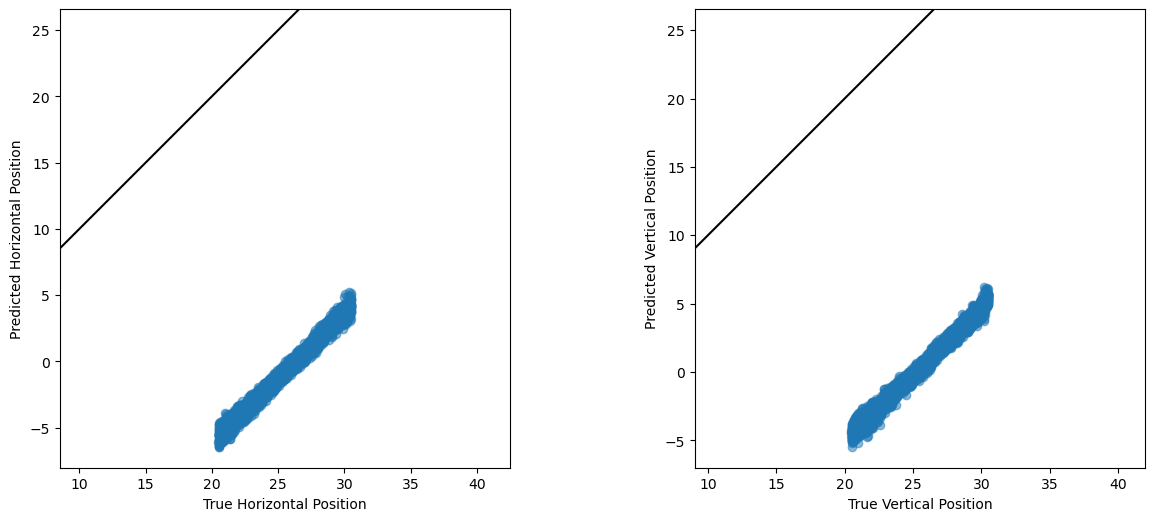

In [13]:
from fnc_lodestar import plot_position_comparison

plot_position_comparison(positions, predictions)

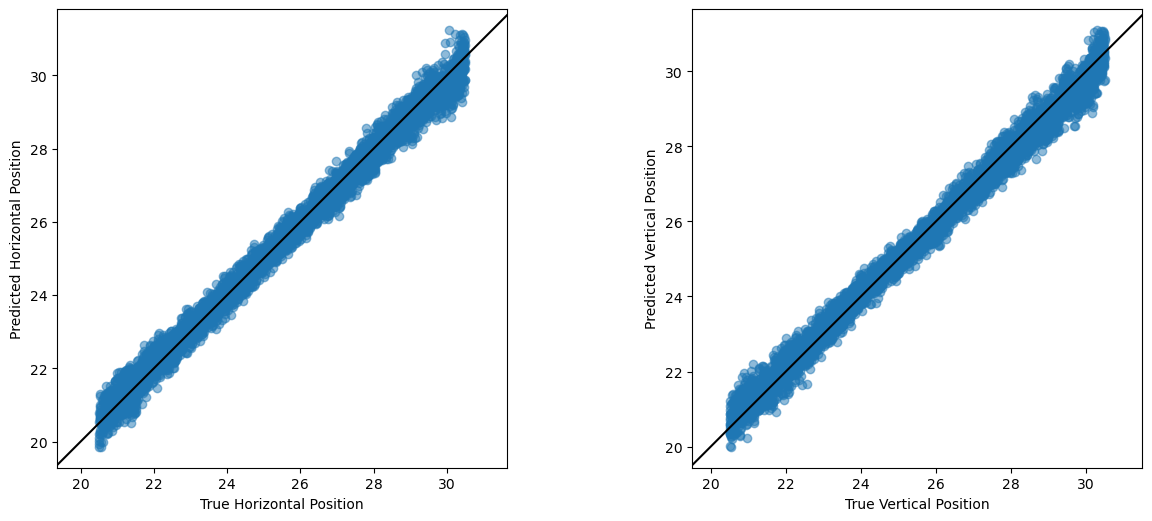

In [14]:
reflected_images = images.flip(dims=(2, 3))

direct_preds = localizer(images).detach().numpy()
reflected_preds = localizer(reflected_images).detach().numpy()

predictions_with_difference = ((direct_preds - reflected_preds) / 2 
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions_with_difference)

## Learn also from Reflections

We now add also reflections to the learning process.

In [15]:
def flip_transform(batch, should_flip, dim):
    """Conditionally reflect bacth along a specified dimension."""
    should_flip = should_flip.view(-1, 1, 1, 1)  # Reshape the should_flip tensor for broadcasting.
    return torch.where(should_flip, batch.flip(dims=(dim,)), batch)  # Flip the images where should_flip is True.

In [16]:
def inverse_flip_transform(preds, should_flip, dim):
    """Conditionally inverse flip transformation based on the should_flip condition."""
    should_flip_mask = torch.zeros_like(preds).bool()
    should_flip_mask[should_flip, dim] = 1
    return torch.where(should_flip_mask, -preds, preds)   # Apply the inverse flip where should_flip_mask is True

In [17]:
class ParticleLocalizerWithReflections(ParticleLocalizer):
    """ParticleLocalizer with additional reflections (flips)."""
    
    def forward_transform(self, batch, translation, flip_x, flip_y):
        """Apply forward translations and reflections to the batch."""
        batch = image_translation(batch, translation)
        batch = flip_transform(batch, flip_x, dim=3)
        batch = flip_transform(batch, flip_y, dim=2)
        return batch
    
    def inverse_transform(self, preds, translation, flip_x, flip_y):
        """Apply the inverse transformations to the predictions."""
        preds = inverse_flip_transform(preds, flip_x, dim=1)
        preds = inverse_flip_transform(preds, flip_y, dim=0)
        preds = inverse_translation(preds, translation)
        return preds
    
    def random_arguments(self):
        """Generate random arguments for translation and reflections."""
        return {
            "translation": (rand(self.n_transforms, 2).float().to(self.device) 
                            * 5 - 2.5),
            "flip_x": rand(self.n_transforms).float().to(self.device) > 0.5,
            "flip_y": rand(self.n_transforms).float().to(self.device) > 0.5,
        }

In [18]:
localizer_with_reflections = ParticleLocalizerWithReflections(
    model, n_transforms=8, loss=nn.L1Loss(), optimizer=dl.Adam(lr=1e-3)
).create()

trainer_with_reflections = dl.Trainer(max_epochs=100)
trainer_with_reflections.fit(localizer_with_reflections, dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 106 K 
1 | loss          | L1Loss           | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
5 | optimizer     | Adam             | 0     
---------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total par

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


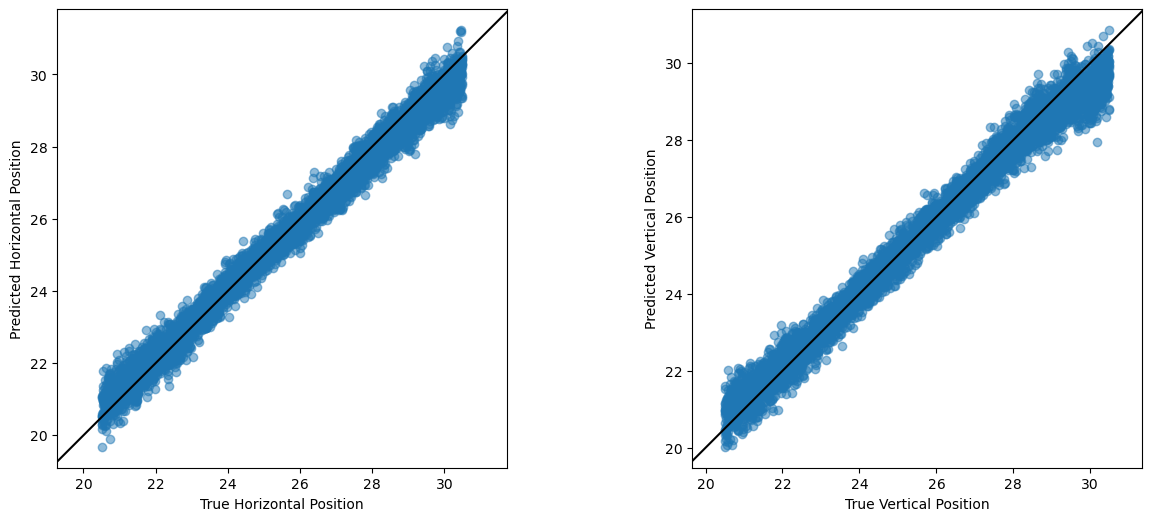

In [19]:
predictions = (localizer_with_reflections(images).detach().numpy() 
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions)

## Improve Performance with LodeSTAR

We can improve the performance using the `LodeSTART` model from `deeplay`.

In [20]:
dataloader_lodestar = DataLoader(train_dataset, batch_size=4, shuffle=True)

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

trainer_lodestar = dl.Trainer(max_epochs=100)
trainer_lodestar.fit(lodestar, dataloader_lodestar)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


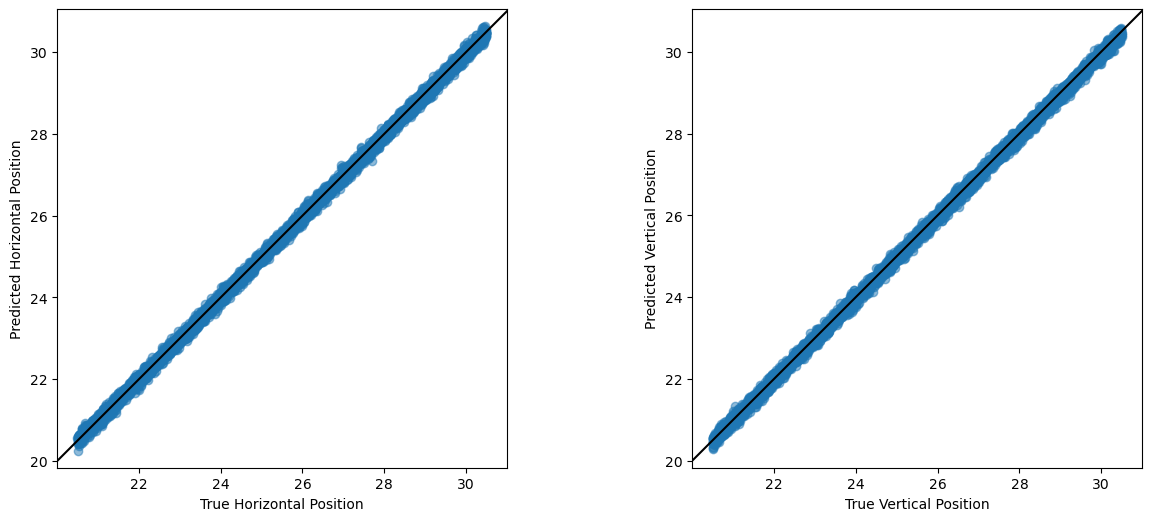

In [21]:
lodestar_predictions = lodestar.pooled(images).detach().numpy() 

plot_position_comparison(positions, lodestar_predictions)